<a href="https://colab.research.google.com/github/tintenderete/TFM-Algoritmo-con-redes-evolutivas/blob/main/EVO/tfm_main1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TEST con so datos obtenidos de ibex_historical_data.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def calculate_sharpe_ratio(returns, risk_free_rate):
    """
    Calcular el ratio de Sharpe

    Parámetros:
    returns (np.array): Array de rendimientos de la inversión
    risk_free_rate (float): Tasa de rendimiento sin riesgo

    Devuelve:
    sharpe_ratio (float): Ratio de Sharpe
    """

    # Calcular el rendimiento promedio
    avg_returns = np.mean(returns)

    # Calcular la desviación estándar de los rendimientos
    std_returns = np.std(returns)

    # Calcular el ratio de Sharpe
    sharpe_ratio = (avg_returns - risk_free_rate) / std_returns

    return sharpe_ratio

# DATOS

In [3]:
import pandas as pd
import numpy as np



In [162]:
def get_data():
  df_ava = pd.read_csv('df_availability.csv')
  df_price = pd.read_csv('df_price_clean_filled.csv')
  df_real = pd.read_csv('df_price_clean_real_value_mask.csv')

  df_ava.index = df_ava.iloc[:,0]
  df_ava = df_ava.drop("date", axis = 1)

  df_price.index = df_price.iloc[:,0]
  df_price = df_price.drop("date", axis = 1)

  df_real.index = df_real.iloc[:,0]
  df_real = df_real.drop("date", axis = 1)

  # ----

  _MIN_porcentage_datos_disponibles_para_DATO = 50.
  _days_backward = 5*4*3
  _days_forward = 15
  _days_steps = 3

  _fechas = df_price.index

  _df_price = df_price
  _df_availability_mask = df_ava
  _df_price_clean_real_value_mask = df_real

  data_x_availability_mask = []
  data_x_real_value_mask = []
  data_x_returns = []
  data_y = []
  data_fechas_start_day = []

  for i in range(_days_backward, len(_fechas), _days_steps):

      _start_day = i-_days_backward
      _end_day = i


      availability_mask = _df_availability_mask[_start_day:_end_day]
      availability_mask = availability_mask.iloc[1:]

      real_value_mask = _df_price_clean_real_value_mask[_start_day:_end_day]
      real_value_mask = real_value_mask.iloc[1:]

      porcentage_datos_disponibles = ( real_value_mask.sum().sum() * 100) / availability_mask.sum().sum()
      dato_corrrecto = porcentage_datos_disponibles >= _MIN_porcentage_datos_disponibles_para_DATO

      if dato_corrrecto == False : continue


      price = _df_price[_start_day:_end_day]
      price = np.log(price).diff().dropna()


      price_forward = _df_price[_end_day:_end_day + _days_forward]
      rs = calculate_sharpe_ratio(np.log(price_forward).diff().dropna(), 0)
      y = np.argsort(np.argsort(rs))


      data_x_availability_mask.append(availability_mask)
      data_x_real_value_mask.append(real_value_mask)
      data_x_returns.append(price)
      data_y.append(y)
      data_fechas_start_day.append(price.index[0])



  data_x_availability_mask = np.array(data_x_availability_mask)
  data_x_real_value_mask = np.array(data_x_real_value_mask)
  data_x_returns = np.array(data_x_returns)
  data_y = np.array(data_y)
  data_fechas_start_day = np.array(data_fechas_start_day)

  # -------

  super_x = np.zeros((
    data_x_availability_mask.shape[0],
    data_x_availability_mask.shape[1],
    data_x_availability_mask.shape[2],
    3))

  super_x[:,:,:,0 ] = data_x_returns
  super_x[:,:,:,1 ] = data_x_real_value_mask
  super_x[:,:,:,2 ] = data_x_availability_mask


  # ---

  Y = data_y

  r_min = np.min(Y, axis=1)[:, np.newaxis]
  r_max = np.max(Y, axis=1)[:, np.newaxis]
  r_min[-1], r_max[-1]

  Y_NORM = 2 * (Y - 0) / (96 - 0) - 1

  X_TRAIN = super_x[:6000]
  Y_TRAIN = Y_NORM[:6000]

  X_TEST = super_x[6000:]
  Y_TEST = Y_NORM[6000:]

  return X_TRAIN, Y_TRAIN, X_TEST, Y_TEST

# TRAIN & VALID & TEST

In [ ]:
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_data()

# 1º Iteracion


# Red Neuronal 1

In [164]:
import keras
from keras import backend as K
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, GRU, concatenate, Dropout, Flatten, ConvLSTM1D , Conv2D

In [165]:
hp_top = 10
hp_incremento_top = 2
def top_is_target(y_true, y_pred ):
  num_samples = K.shape(y_true)[0]

  w = K.arange(96, dtype='float32')
  w = K.reverse(w, axes=0) + 1

  w = tf.where(K.arange(96) < hp_top, w * hp_incremento_top, w)
  # Replicar w a lo largo del eje 0 (batch)
  #w = K.repeat_elements(K.expand_dims(w, 0), num_samples, axis=0)
  w = tf.tile(K.expand_dims(w, 0), [num_samples, 1])

  # Calcular la pérdida
  r = K.cast(y_true, 'float32')
  r_pred = K.cast(y_pred, 'float32')

  return K.sum(w * K.square(r - r_pred), axis=-1)

In [166]:
X_TRAIN.shape

(2515, 59, 96, 3)

In [207]:
from keras.layers import Input, TimeDistributed, Conv1D, Flatten, GRU, Dense, Concatenate
from keras.models import Model
import keras

# Tus datos de entrada siguen siendo (167, 96, 3)
input1 = Input(shape=(X_TRAIN.shape[1], X_TRAIN.shape[2]))

N = 4
DO = 0.6

m1 = GRU(N)(input1)
m1 = Dropout(DO)(m1)

Input2 = Input(shape=(X_TRAIN.shape[1], X_TRAIN.shape[2]))
m2 = Dense(N)(Input2)

Input3 = Input(shape=(X_TRAIN.shape[1], X_TRAIN.shape[2]))
m3 = Dense(N)(Input3)

concatenated = Concatenate(axis=-1)([m2, m3])

concatenated = Dense(N)(concatenated)

concatenated = Flatten()(concatenated)

concatenated = Concatenate(axis=-1)([concatenated, m1])

concatenated = Dense(N)(concatenated)

concatenated = Dropout(DO)(concatenated)

output = Dense(Y_TRAIN.shape[1], activation='tanh')(concatenated)

model = Model(inputs=[input1,Input2, Input3] , outputs=output)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=top_is_target, metrics=[])

model.summary()

Model: "model_84"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_140 (InputLayer)         [(None, 59, 96)]     0           []                               
                                                                                                  
 input_141 (InputLayer)         [(None, 59, 96)]     0           []                               
                                                                                                  
 dense_210 (Dense)              (None, 59, 4)        388         ['input_140[0][0]']              
                                                                                                  
 dense_211 (Dense)              (None, 59, 4)        388         ['input_141[0][0]']              
                                                                                           

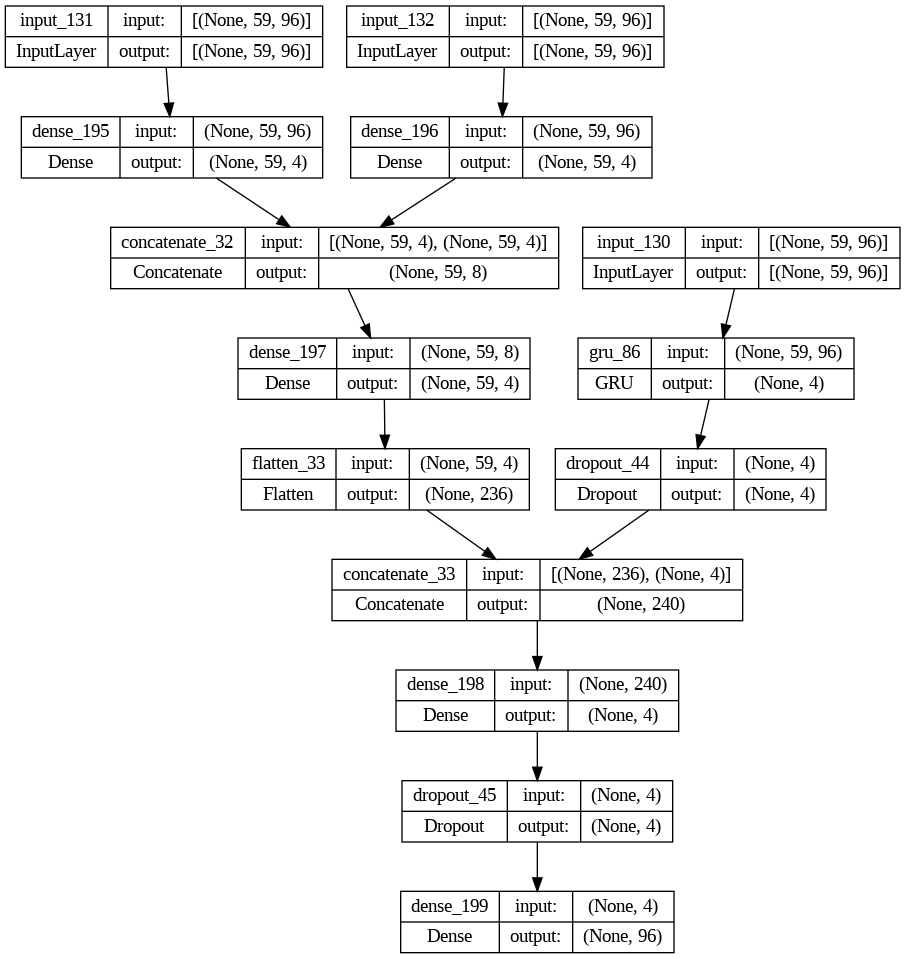

In [202]:
from keras.utils import plot_model

# Asumiendo que tu modelo ya ha sido definido y se llama "model"
plot_model(model, show_shapes=True, show_layer_names=True)


In [10]:
X_TRAIN.shape

(6000, 167, 96, 3)

In [11]:
Y_TRAIN.shape

(6000, 96)

In [82]:
X_TRAIN[:,:,:,-1].shape

(6000, 167, 96)

In [208]:
h = model.fit(
        [ X_TRAIN[:,:,:,0], X_TRAIN[:,:,:,1], X_TRAIN[:,:,:,2] ],
        Y_TRAIN,
        epochs=500,
        batch_size=X_TRAIN.shape[0],
        validation_split = 0.2,
        shuffle=True,
        verbose = True
          )

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 4000.9329 - val_loss: 2412.4128
Epoch 2/500
1/1 [==============================] - 0s 88ms/step - loss: 3192.2383 - val_loss: 2559.7214
Epoch 3/500
1/1 [==============================] - 0s 80ms/step - loss: 2881.6528 - val_loss: 2562.0649
Epoch 4/500
1/1 [==============================] - 0s 82ms/step - loss: 2947.2893 - val_loss: 2249.1438
Epoch 5/500
1/1 [==============================] - 0s 89ms/step - loss: 2706.0894 - val_loss: 2133.5808
Epoch 6/500
1/1 [==============================] - 0s 80ms/step - loss: 2483.9683 - val_loss: 2179.5740
Epoch 7/500
1/1 [==============================] - 0s 81ms/step - loss: 2482.8787 - val_loss: 2036.0793
Epoch 8/500
1/1 [==============================] - 0s 80ms/step - loss: 2430.7524 - val_loss: 1778.3430
Epoch 9/500
1/1 [==============================] - 0s 81ms/step - loss: 2335.5681 - val_loss: 1591.7390
Epoch 10/500
1/1 [==============================] - 0s 80ms/step -

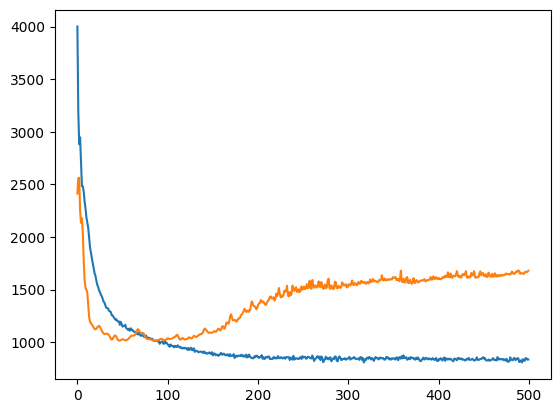

In [209]:
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])

# Red Neuronal 2

In [160]:
from keras.layers import Input, TimeDistributed, Conv1D, Flatten, GRU, Dense
from keras.models import Model
import keras

# Tus datos de entrada siguen siendo (167, 96, 3)
input1 = Input(shape=(167, 96, 3))

m = ConvLSTM1D(30,30)(input1)

m = Flatten()(m)

output = Dense(Y_TRAIN.shape[1], activation='tanh')(m)

model = Model(inputs=input1, outputs=output)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=top_is_target, metrics=[])

model.summary()

Model: "model_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_73 (InputLayer)       [(None, 167, 96, 3)]      0         
                                                                 
 conv_lstm1d_13 (ConvLSTM1D)  (None, 67, 30)           118920    
                                                                 
 flatten_19 (Flatten)        (None, 2010)              0         
                                                                 
 dense_108 (Dense)           (None, 96)                193056    
                                                                 
Total params: 311,976
Trainable params: 311,976
Non-trainable params: 0
_________________________________________________________________


In [161]:
h = model.fit(
        X_TRAIN,
        Y_TRAIN,
        epochs=500,
        batch_size=1,
        validation_split = 0.2,
        shuffle=True,
        verbose = True
          )

Epoch 1/500
 155/4800 [..............................] - ETA: 23:23 - loss: 4115.3345

KeyboardInterrupt: ignored

# Evolutivo

In [ ]:
from evo import GeneticAlgorithm
from evo import I1_simple_gru
import timeit

In [ ]:
i1 = I1_simple_gru()

In [ ]:
population_size = 10
n_generations = 3
n_save_best_population = 3
n_inds_selection_function = 6
epochs=2
initial_population = i1.initial_population(population_size)

# assuming that X and Y are your data
ga = GeneticAlgorithm(
    initial_population=initial_population,
    fitness_function=lambda population: i1.fitness_function(population, X_TRAIN, Y_TRAIN, X_VALID, Y_VALID, epochs=epochs),
    selection_function=lambda population, fitness: i1.selection_function(population, fitness, n_inds_selection_function),
    crossover_function= i1.crossover_function,
    mutation_function=lambda population:  population,
    immigration_function=lambda: i1.initial_population(population_size),
    n_generations=n_generations,
    n_save_best_population=n_save_best_population
)

In [ ]:
n_episodios = 3


fitness_evo = []

for i in range(n_episodios):
    print(i)
    start_time = timeit.default_timer()
    # ENTRENAMOS N GENERACIONES
    best_solution = ga.run()

    fitness_evo.append(ga.fitness.min())

    end_time = timeit.default_timer()
    execution_time = end_time - start_time
    print(f"El tiempo de ejecución fue: {execution_time} segundos")

    fig , axs = plt.subplots(2,3, figsize=(10,10))

    axs[0,0].hist(ga.population[:,0])
    axs[0,0].set_title('n_neurons_gru')

    axs[0,1].hist(ga.population[:,1])
    axs[0,1].set_title('l1_gru')

    axs[0,2].hist(ga.population[:,2])
    axs[0,2].set_title('l2_gru')

    axs[1,0].hist(ga.population[:,3])
    axs[1,0].set_title('dropout')

    axs[1,1].hist(ga.population[:,4])
    axs[1,1].set_title('n_dense_layers')

    axs[1,2].hist(ga.population[:,5])
    axs[1,2].set_title('n_neurons_dense')



    fig.suptitle('EPISODIO: ' + str(i), fontsize=16)


    plt.show()


plt.plot(fitness_evo)

# RN vs EVO